In [50]:
import unicodedata
import pandas as pd
import numpy as np
import string
import sys
import re
import sklearn
import nltk

from nltk import FreqDist
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.classify.scikitlearn import  #SKlearnClassifier
from nltk.classify import SklearnClassifier

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

np.set_printoptions(linewidth=100)

%autosave 120

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/yamasjose/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yamasjose/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yamasjose/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Autosaving every 120 seconds


###  Importing Data

In [2]:
# if on google colab

# import io
# from google.colab import files 
# uploaded = files.upload()

# twitter = pd.read_csv(io.StringIO(uploaded['data/gender-classifier-DFE-791531.csv'].decode('utf-8')))

In [3]:
twitter = pd.read_csv('data/gender-classifier-DFE-791531.csv', encoding='latin-1' )

The dataset contains the following fields:

**unit_id:** a unique id for user

**golden:** whether the user was included in the gold standard for the model; TRUE or FALSE

**unit_state:** state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)

**trusted_judgments:** number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations

**last_judgment_at:** date and time of last contributor judgment; blank for gold standard observations

**gender:** one of male, female, or brand (for non-human profiles)

**gender:confidence:** a float representing confidence in the provided gender

**profile_yn:** "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it

**profile_yn:confidence:** confidence in the existence/non-existence of the profile

**created:** date and time when the profile was created

**description:** the user's profile description

**fav_number:** number of tweets the user has favorited

**gender_gold:** if the profile is golden, what is the gender?

**link_color:** the link color on the profile, as a hex value

**name:** the user's name

**profile_yn_gold:** whether the profile y/n value is golden

**profileimage:** a link to the profile image

**retweet_count:** number of times the user has retweeted (or possibly, been retweeted)

**sidebar_color:** color of the profile sidebar, as a hex value

**text:** text of a random one of the user's tweets

**tweet_coord:** if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"

**tweet_count:** number of tweets that the user has posted

**tweet_created:** when the random tweet (in the text column) was created

**tweet_id:** the tweet id of the random tweet

**tweet_location:** location of the tweet; seems to not be particularly normalized

**user_timezone:** the timezone of the user

In [4]:
pd.set_option('display.max_columns', None)

twitter.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [5]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

### Exploring data and cleaning it


In [6]:
twitter = twitter.drop(['_golden', '_unit_state', '_trusted_judgments', 'profile_yn', 'gender_gold', 'profile_yn_gold', 'tweet_coord', 'tweet_location', 'user_timezone'], axis = 1) 
# clean_df

In [7]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _last_judgment_at      20000 non-null  object 
 2   gender                 19953 non-null  object 
 3   gender:confidence      20024 non-null  float64
 4   profile_yn:confidence  20050 non-null  float64
 5   created                20050 non-null  object 
 6   description            16306 non-null  object 
 7   fav_number             20050 non-null  int64  
 8   link_color             20050 non-null  object 
 9   name                   20050 non-null  object 
 10  profileimage           20050 non-null  object 
 11  retweet_count          20050 non-null  int64  
 12  sidebar_color          20050 non-null  object 
 13  text                   20050 non-null  object 
 14  tweet_count            20050 non-null  int64  
 15  tw

In [8]:
# fill in missing data
twitter.fillna(value = 'unknown',  
          inplace = True) 

In [9]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _last_judgment_at      20050 non-null  object 
 2   gender                 20050 non-null  object 
 3   gender:confidence      20050 non-null  object 
 4   profile_yn:confidence  20050 non-null  float64
 5   created                20050 non-null  object 
 6   description            20050 non-null  object 
 7   fav_number             20050 non-null  int64  
 8   link_color             20050 non-null  object 
 9   name                   20050 non-null  object 
 10  profileimage           20050 non-null  object 
 11  retweet_count          20050 non-null  int64  
 12  sidebar_color          20050 non-null  object 
 13  text                   20050 non-null  object 
 14  tweet_count            20050 non-null  int64  
 15  tw

In [10]:
twitter.gender.value_counts()

female     6700
male       6194
brand      5942
unknown    1214
Name: gender, dtype: int64

## NLP Pipeline 

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors



In [11]:
# twitter

In [162]:
type(twitter.gender), type(twitter.text)

(pandas.core.series.Series, pandas.core.series.Series)

In [13]:
classes = twitter['gender']
print(classes.value_counts())

female     6700
male       6194
brand      5942
unknown    1214
Name: gender, dtype: int64


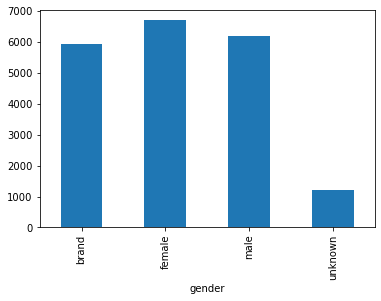

In [160]:
# tweets per gender per data
twitter.groupby('gender').text.count().plot.bar(ylim=0)
plt.show()

In [161]:
# plot of "words" per gender?


In [15]:
encoder = LabelEncoder()
Y = encoder.fit_transform(classes)

# print(classes[:15])
print(Y[:15])

[2 2 2 2 1 1 0 2 1 1 0 0 1 0 1]


In [16]:
twitter.text[:15]

0     Robbie E Responds To Critics After Win Against...
1     ÛÏIt felt like they were my friends and I was...
2     i absolutely adore when louis starts the songs...
3     Hi @JordanSpieth - Looking at the url - do you...
4     Watching Neighbours on Sky+ catching up with t...
5     Ive seen people on the train with lamps, chair...
6     @BpackEngineer Thank you for your patience whi...
7     Gala Bingo clubs bought for å£241m: The UK's l...
8     @_Aphmau_ the pic defines all mcd fangirls/fan...
9     @Evielady just how lovely is the tree this yea...
10    how are you taking care of yourself? https://t...
11    MTG Deals 1x Rank-Up-Magic - The Seventh One -...
12    Just put my ass on the line for you and this i...
13    https://t.co/z4sbWUugd8 What the Nation Will B...
14    will i even need sound effects for the diviner...
Name: text, dtype: object

In [85]:
tweets = twitter.text
tweets

0        Robbie E Responds To Critics After Win Against...
1        UIIt felt like they were my friends and I was ...
2        i absolutely adore when louis starts the songs...
3        Hi - Looking at the url - do you use Don't typ...
4        Watching Neighbours on Sky+ catching up with t...
                               ...                        
20045         ...Fine, and I'll drink tea too. I love you.
20046    Greg Hardy you a good player and all but don't...
20047    You can miss people and still never want to se...
20048    i had noticed your tendency to pee on the carp...
20049    I think for my APUSH creative project I'm goin...
Name: text, Length: 20050, dtype: object

###   Clean text and Create a Bag of Words (BoW)

In [18]:
pt = string.punctuation
pt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
# removing @s and links
for i,doc in enumerate(tweets):
    tweets[i] = re.sub(r"(?:\@|https?\://)\S+", "", doc)
    tweets[i] = " ".join(tweets[i].split())
# tweets[:15]

/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
# We will analyze not using emojis and re iterate through the same data with emojis

# let's start by removing emojis and other special characters
for i,doc in enumerate(tweets):
    tweets[i] = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')

# tweets, len(tweets)

/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [21]:
# clean punctuation
tweets = tweets.str.replace(r'[^\w\d\s]', ' ')
# clean_tweets[:20]

In [22]:
# clean numbers
tweets = tweets.str.replace(r'\d+(\.\d+)?', ' ')
# tweets[:20]

In [23]:
# clean whitespaces
tweets = tweets.str.replace(r'\s+', ' ')
# tweets[:20]

In [24]:
# clean extra whitespaces
tweets = tweets.str.replace(r'^\s+|\s+?$', '')
# tweets[:20]

In [25]:
# lower
tweets = tweets.str.lower()
tweets[:20]

0     robbie e responds to critics after win against...
1     uiit felt like they were my friends and i was ...
2     i absolutely adore when louis starts the songs...
3     hi looking at the url do you use don t typical...
4     watching neighbours on sky catching up with th...
5     ive seen people on the train with lamps chairs...
6     thank you for your patience while we take care...
7     gala bingo clubs bought for a m the uk s large...
8     the pic defines all mcd fangirls fanboys and m...
9     just how lovely is the tree this year never se...
10     how are you taking care of yourself fitfluential
11    mtg deals x rank up magic the seventh one prio...
12    just put my ass on the line for you and this i...
13    what the nation will be talking about after we...
14    will i even need sound effects for the diviner...
15              it s a glow of satisfaction re the glow
16    lmao _ua_ua dude i m hella scared for next epi...
17    ditto i m still learning the favourites an

In [26]:
# remove stop words
stop_words = set(stopwords.words('english'))

tweets = tweets.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
tweets[:15]

0     robbie e responds critics win eddie edwards wo...
1     uiit felt like friends living story themu reti...
2     absolutely adore louis starts songs hits hard ...
3        hi looking url use typically see advanced user
4     watching neighbours sky catching neighbs xxx _...
5            ive seen people train lamps chairs tvs etc
6                        thank patience take care issue
7     gala bingo clubs bought uk largest high street...
8      pic defines mcd fangirls fanboys mcd shippers xd
9     lovely tree year never seen gorgeous autumn co...
10                             taking care fitfluential
11    mtg deals x rank magic seventh one prio en sec...
12                                   put ass line repay
13        nation talking wednesday gop debates business
14             even need sound effects diviners tonight
Name: text, dtype: object

In [27]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

porter_tweets = tweets.apply(lambda x: ' '.join(porter.stem(word) for word in x.split()))
snowball_tweets = tweets.apply(lambda x: ' '.join(snowball.stem(word) for word in x.split()))
wordnet_tweets = tweets.apply(lambda x: ' '.join(wordnet.lemmatize(word) for word in x.split()))

# porter_tweets

In [28]:
# create function to call on snowball and wordnet
bow_fd = []
for x in porter_tweets:
    words = word_tokenize(x)
    for w in words:
        bow_fd.append(w)
        
bow_fd = nltk.FreqDist(bow_fd)

In [29]:
print('num : {}'.format(len(bow_fd)))
print('common: {}'.format(bow_fd.most_common(20)))

num : 20883
common: [('weather', 2709), ('get', 2533), ('updat', 1413), ('channel', 1393), ('like', 1125), ('go', 888), ('one', 862), ('love', 845), ('make', 834), ('day', 768), ('time', 715), ('new', 703), ('look', 615), ('amp', 565), ('peopl', 564), ('see', 558), ('know', 556), ('want', 547), ('follow', 533), ('last', 490)]


In [30]:
bow_fd

FreqDist({'weather': 2709, 'get': 2533, 'updat': 1413, 'channel': 1393, 'like': 1125, 'go': 888, 'one': 862, 'love': 845, 'make': 834, 'day': 768, ...})

In [31]:
word_lim_1000 = list(bow_fd.keys())[:1000]
word_lim_1000

['robbi',
 'e',
 'respond',
 'critic',
 'win',
 'eddi',
 'edward',
 'worldtitleseri',
 'uiit',
 'felt',
 'like',
 'friend',
 'live',
 'stori',
 'themu',
 'retir',
 'ian',
 'absolut',
 'ador',
 'loui',
 'start',
 'song',
 'hit',
 'hard',
 'feel',
 'good',
 'hi',
 'look',
 'url',
 'use',
 'typic',
 'see',
 'advanc',
 'user',
 'watch',
 'neighbour',
 'sky',
 'catch',
 'neighb',
 'xxx',
 '_ua_ua_ua_uoi_ue_uo_u',
 'ive',
 'seen',
 'peopl',
 'train',
 'lamp',
 'chair',
 'tv',
 'etc',
 'thank',
 'patienc',
 'take',
 'care',
 'issu',
 'gala',
 'bingo',
 'club',
 'bought',
 'uk',
 'largest',
 'high',
 'street',
 'oper',
 'taken',
 'byu_',
 'pic',
 'defin',
 'mcd',
 'fangirl',
 'fanboy',
 'shipper',
 'xd',
 'love',
 'tree',
 'year',
 'never',
 'gorgeou',
 'autumn',
 'colour',
 'fitfluenti',
 'mtg',
 'deal',
 'x',
 'rank',
 'magic',
 'seventh',
 'one',
 'prio',
 'en',
 'secret',
 'rare',
 'unlimi',
 'put',
 'ass',
 'line',
 'repay',
 'nation',
 'talk',
 'wednesday',
 'gop',
 'debat',
 'busi',
 'e

In [32]:
word_lim_5000 = list(bow_fd.keys())[:5000]
word_lim_5000

['robbi',
 'e',
 'respond',
 'critic',
 'win',
 'eddi',
 'edward',
 'worldtitleseri',
 'uiit',
 'felt',
 'like',
 'friend',
 'live',
 'stori',
 'themu',
 'retir',
 'ian',
 'absolut',
 'ador',
 'loui',
 'start',
 'song',
 'hit',
 'hard',
 'feel',
 'good',
 'hi',
 'look',
 'url',
 'use',
 'typic',
 'see',
 'advanc',
 'user',
 'watch',
 'neighbour',
 'sky',
 'catch',
 'neighb',
 'xxx',
 '_ua_ua_ua_uoi_ue_uo_u',
 'ive',
 'seen',
 'peopl',
 'train',
 'lamp',
 'chair',
 'tv',
 'etc',
 'thank',
 'patienc',
 'take',
 'care',
 'issu',
 'gala',
 'bingo',
 'club',
 'bought',
 'uk',
 'largest',
 'high',
 'street',
 'oper',
 'taken',
 'byu_',
 'pic',
 'defin',
 'mcd',
 'fangirl',
 'fanboy',
 'shipper',
 'xd',
 'love',
 'tree',
 'year',
 'never',
 'gorgeou',
 'autumn',
 'colour',
 'fitfluenti',
 'mtg',
 'deal',
 'x',
 'rank',
 'magic',
 'seventh',
 'one',
 'prio',
 'en',
 'secret',
 'rare',
 'unlimi',
 'put',
 'ass',
 'line',
 'repay',
 'nation',
 'talk',
 'wednesday',
 'gop',
 'debat',
 'busi',
 'e

In [33]:
def features_(x, word_lim):
    words = word_tokenize(x)
    features = {}
    for y in word_lim:
        features[x] = (x in words)
        
    return features

### Porter

In [34]:
tweet_features = list(zip(porter_tweets, Y))

seed = 1
np.random.seed = seed
np.random.shuffle(tweet_features)

features = [(features_(x, word_lim_5000), marker) for (text, marker) in tweet_features]

In [35]:
training, testing = model_selection.train_test_split(features, test_size=0.2)

len(training), len(testing)

(16040, 4010)

In [53]:
names = ['K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Log Regression', 'Naive Bayes', 'SVM Linear']

classifiers = [KNeighborsClassifier(), 
              DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              LogisticRegression(), 
              MultinomialNB(), 
              SVC()]

models = list(zip(names, classifiers))

In [54]:
for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    acc = nltk.classify.accuracy(nltk_model, testing)
    print('{}: ACC: {}'.format(name, acc))

K Nearest Neighbors: ACC: 0.31022443890274315
Decision Tree: ACC: 0.3374064837905237
Random Forest: ACC: 0.3374064837905237
Log Regression: ACC: 0.3374064837905237
Naive Bayes: ACC: 0.3374064837905237
SVM Linear: ACC: 0.3374064837905237


## Snow

In [55]:
# create function to call on snowball and wordnet
bow_fd_snow = []
for x in snowball_tweets:
    words = word_tokenize(x)
    for w in words:
        bow_fd_snow.append(w)
        
bow_fd_snow = nltk.FreqDist(bow_fd)

print('num : {}'.format(len(bow_fd_snow)))
print('common: {}'.format(bow_fd_snow.most_common(20)))

num : 20883
common: [('weather', 2709), ('get', 2533), ('updat', 1413), ('channel', 1393), ('like', 1125), ('go', 888), ('one', 862), ('love', 845), ('make', 834), ('day', 768), ('time', 715), ('new', 703), ('look', 615), ('amp', 565), ('peopl', 564), ('see', 558), ('know', 556), ('want', 547), ('follow', 533), ('last', 490)]


In [56]:
tweet_features_snow = list(zip(snowball_tweets, Y))

seed = 1
np.random.seed = seed
np.random.shuffle(tweet_features_snow)

features_snow = [(features_(x, word_lim_5000), marker) for (text, marker) in tweet_features_snow]

In [57]:
training_snow, testing_snow = model_selection.train_test_split(features_snow, test_size=0.2)

len(training_snow), len(testing_snow)

(16040, 4010)

In [59]:
for name, model in models:
    nltk_model_snow = SklearnClassifier(model)
    nltk_model_snow.train(training_snow)
    acc_snow = nltk.classify.accuracy(nltk_model_snow, testing_snow)
    print('{}: ACC: {}'.format(name, acc_snow))

K Nearest Neighbors: ACC: 0.28603491271820447
Decision Tree: ACC: 0.33092269326683293
Random Forest: ACC: 0.33092269326683293
Log Regression: ACC: 0.33092269326683293
Naive Bayes: ACC: 0.33092269326683293
SVM Linear: ACC: 0.33092269326683293


### Wordnet

In [60]:
# create function to call on snowball and wordnet
bow_fd_wordnet = []
for x in wordnet_tweets:
    words = word_tokenize(x)
    for w in words:
        bow_fd_wordnet.append(w)
        
bow_fd_wordnet = nltk.FreqDist(bow_fd)

print('num : {}'.format(len(bow_fd_wordnet)))
print('common: {}'.format(bow_fd_wordnet.most_common(20)))

num : 20883
common: [('weather', 2709), ('get', 2533), ('updat', 1413), ('channel', 1393), ('like', 1125), ('go', 888), ('one', 862), ('love', 845), ('make', 834), ('day', 768), ('time', 715), ('new', 703), ('look', 615), ('amp', 565), ('peopl', 564), ('see', 558), ('know', 556), ('want', 547), ('follow', 533), ('last', 490)]


In [82]:
tweet_features_wordnet = list(zip(wordnet_tweets, Y))

seed = 1
np.random.seed = seed
np.random.shuffle(tweet_features_wordnet)

features_wordnet = [(features_(x, word_lim_5000), marker) for (text, marker) in tweet_features_wordnet]

In [83]:
training_wordnet, testing_wordnet = model_selection.train_test_split(features_wordnet, test_size=0.2)

len(training_wordnet), len(testing_wordnet)

(16040, 4010)

In [84]:
for name, model in models:
    nltk_model_wordnet = SklearnClassifier(model)
    nltk_model_wordnet.train(training_wordnet)
    acc_wordnet = nltk.classify.accuracy(nltk_model_wordnet, testing_wordnet)
    print('{}: ACC: {}'.format(name, acc_wordnet))

K Nearest Neighbors: ACC: 0.31546134663341646
Decision Tree: ACC: 0.33266832917705735
Random Forest: ACC: 0.33266832917705735
Log Regression: ACC: 0.33266832917705735
Naive Bayes: ACC: 0.33266832917705735
SVM Linear: ACC: 0.33266832917705735


## Seperation of Genders

In [86]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _last_judgment_at      20050 non-null  object 
 2   gender                 20050 non-null  object 
 3   gender:confidence      20050 non-null  object 
 4   profile_yn:confidence  20050 non-null  float64
 5   created                20050 non-null  object 
 6   description            20050 non-null  object 
 7   fav_number             20050 non-null  int64  
 8   link_color             20050 non-null  object 
 9   name                   20050 non-null  object 
 10  profileimage           20050 non-null  object 
 11  retweet_count          20050 non-null  int64  
 12  sidebar_color          20050 non-null  object 
 13  text                   20050 non-null  object 
 14  tweet_count            20050 non-null  int64  
 15  tw

In [94]:
twitter.gender.value_counts()

female     6700
male       6194
brand      5942
unknown    1214
Name: gender, dtype: int64

In [155]:
male = [twitter['gender'] ==  'Male']
male

[0        False
 1        False
 2        False
 3        False
 4        False
          ...  
 20045    False
 20046    False
 20047    False
 20048    False
 20049    False
 Name: gender, Length: 20050, dtype: bool]

In [101]:
classes = twitter['gender']
print(classes.value_counts())

female     6700
male       6194
brand      5942
unknown    1214
Name: gender, dtype: int64


In [103]:
encoder = LabelEncoder()
Y = encoder.fit_transform(classes)

print(classes[:15])
print(Y[:25])

0       male
1       male
2       male
3       male
4     female
5     female
6      brand
7       male
8     female
9     female
10     brand
11     brand
12    female
13     brand
14    female
Name: gender, dtype: object
[2 2 2 2 1 1 0 2 1 1 0 0 1 0 1 1 1 2 2 3 1 1 1 2 2]


## NLP Case Study Overview with twitter data

In [122]:
documents = twitter['text']
documents

0        Robbie E Responds To Critics After Win Against...
1        UIIt felt like they were my friends and I was ...
2        i absolutely adore when louis starts the songs...
3        Hi - Looking at the url - do you use Don't typ...
4        Watching Neighbours on Sky+ catching up with t...
                               ...                        
20045         ...Fine, and I'll drink tea too. I love you.
20046    Greg Hardy you a good player and all but don't...
20047    You can miss people and still never want to se...
20048    i had noticed your tendency to pee on the carp...
20049    I think for my APUSH creative project I'm goin...
Name: text, Length: 20050, dtype: object

In [115]:
# Set Stop Words
stop = set(stopwords.words('english'))
# Set Stop Punctuations
puncs = set(string.punctuation)
# Merge Stops
full_stop = stop.union(puncs)
# full_stop

In [116]:
def remove_accents(input_str:str) -> str:
    '''Removes accents from input string'''
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

def filter_tokens(tokens:list, stops:object) -> list:
    """Filters tokens base on membership in stop list"""
#     split_punc = lambda x: 
    res = []
    check = [".", "-"]
    for token in tokens:
        if token not in stops and token.isalpha():
            if check[0] in token:
                res += token.partition(check[0])
            elif check[1] in token:
                res += token.partition(check[1])
            else:
                res.append(token)
    return res

In [117]:
# Tokenize Words from Documents
tokens = [word_tokenize(doc.lower()) for doc in documents]

# Filter each token for stop words
doc_filter = [filter_tokens(token, full_stop) for token in tokens]

In [123]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

docs_porter = [[porter.stem(word) for word in words]
               for words in doc_filter]
docs_snowball = [[snowball.stem(word) for word in words]
                 for words in doc_filter]
docs_wordnet = [[wordnet.lemmatize(word) for word in words]
                for words in doc_filter]

# docs_porter

[['robbi',
  'e',
  'respond',
  'critic',
  'win',
  'eddi',
  'edward',
  'worldtitleseri'],
 ['uiit', 'felt', 'like', 'friend', 'live', 'stori', 'themu', 'retir'],
 ['absolut', 'ador', 'loui', 'start', 'song', 'hit', 'hard', 'feel', 'good'],
 ['hi', 'look', 'url', 'use', 'typic', 'see', 'advanc', 'user'],
 ['watch', 'neighbour', 'catch', 'neighb', 'xxx', 'xxx'],
 ['ive', 'seen', 'peopl', 'train', 'lamp', 'chair', 'tv', 'etc'],
 ['thank', 'patienc', 'take', 'care', 'issu'],
 ['gala',
  'bingo',
  'club',
  'bought',
  'uk',
  'largest',
  'high',
  'street',
  'bingo',
  'oper',
  'gala',
  'taken'],
 ['pic', 'defin', 'mcd', 'mcd', 'shipper', 'xd'],
 ['love', 'tree', 'year', 'never', 'seen', 'gorgeou', 'autumn', 'colour'],
 ['take', 'care', 'fitfluenti'],
 ['mtg', 'deal', 'seventh', 'one', 'secret', 'rare', 'unlimi'],
 ['put', 'ass', 'line', 'repay'],
 ['nation', 'talk', 'wednesday', 'gop', 'debat', 'busi'],
 ['even', 'need', 'sound', 'effect', 'divin', 'tonight'],
 ['glow', 'satisfa

In [119]:
## Print the stemmed and lemmatized words from the first document
print("%16s | %16s | %16s | %16s |" % ("WORD", "PORTER", "SNOWBALL", "LEMMATIZER"))
for i in range(min(len(docs_porter[0]), len(docs_snowball[0]), len(docs_wordnet[0]))):
    p, s, w = docs_porter[0][i], docs_snowball[0][i], docs_wordnet[0][i]
    if len(set((p, s, w))) != 1:
        print("%16s | %16s | %16s | %16s |" % (doc_filter[0][i], p, s, w))

            WORD |           PORTER |         SNOWBALL |       LEMMATIZER |
          robbie |            robbi |            robbi |           robbie |
        responds |          respond |          respond |         responds |
           eddie |             eddi |             eddi |            eddie |
worldtitleseries |   worldtitleseri |   worldtitleseri | worldtitleseries |


In [124]:
# Stem Words in Each Document
clean_tokens = [list(map(snowball.stem, sent)) for sent in doc_filter]
# clean_tokens

In [125]:
# Check for stray tokens (ones with weird puncs, not alphabetical strings)
strays = []
for i in range(len(clean_tokens)):
#     print("--- sentence tokens (lemmatize): {}".format(tokens_lemmatize[i]))
    for word in clean_tokens[i]:
        if not word.isalpha():
            strays.append(word)
set(strays)

set()

In [127]:
document_series = pd.Series([" ".join(x) for x in clean_tokens])
document_series

0        robbi e respond critic win eddi edward worldti...
1             uiit felt like friend live stori themu retir
2          absolut ador loui start song hit hard feel good
3                    hi look url use typic see advanc user
4                     watch neighbour catch neighb xxx xxx
                               ...                        
20045                                  fine drink tea love
20046    greg hardi good player get face dez bryant lea...
20047                      miss peopl still never want see
20048            notic tendenc pee carpet want say anyth p
20049    think apush creativ project go bring bacon cla...
Length: 20050, dtype: object

In [129]:
from collections import Counter

# term occurence = counting distinct words in each bag
term_occ = [Counter(doc) for doc in clean_tokens]
term_occ

[Counter({'robbi': 1,
          'e': 1,
          'respond': 1,
          'critic': 1,
          'win': 1,
          'eddi': 1,
          'edward': 1,
          'worldtitleseri': 1}),
 Counter({'uiit': 1,
          'felt': 1,
          'like': 1,
          'friend': 1,
          'live': 1,
          'stori': 1,
          'themu': 1,
          'retir': 1}),
 Counter({'absolut': 1,
          'ador': 1,
          'loui': 1,
          'start': 1,
          'song': 1,
          'hit': 1,
          'hard': 1,
          'feel': 1,
          'good': 1}),
 Counter({'hi': 1,
          'look': 1,
          'url': 1,
          'use': 1,
          'typic': 1,
          'see': 1,
          'advanc': 1,
          'user': 1}),
 Counter({'watch': 1, 'neighbour': 1, 'catch': 1, 'neighb': 1, 'xxx': 2}),
 Counter({'ive': 1,
          'seen': 1,
          'peopl': 1,
          'train': 1,
          'lamp': 1,
          'chair': 1,
          'tvs': 1,
          'etc': 1}),
 Counter({'thank': 1, 'patienc': 1

In [130]:
term_freq = list()
for i in range(len(clean_tokens)):
    term_freq.append( {k: (v / float(len(clean_tokens[i])))
                       for k, v in term_occ[i].items()} )
term_freq[0]

{'robbi': 0.125,
 'e': 0.125,
 'respond': 0.125,
 'critic': 0.125,
 'win': 0.125,
 'eddi': 0.125,
 'edward': 0.125,
 'worldtitleseri': 0.125}

In [132]:
doc_occ = Counter( [word for token in clean_tokens for word in set(token)] )

doc_freq = {k: (v / float(len(clean_tokens)))
            for k, v in doc_occ.items()}

doc_freq

{'critic': 0.0010972568578553616,
 'respond': 0.0008977556109725686,
 'edward': 0.00034912718204488776,
 'robbi': 4.987531172069826e-05,
 'worldtitleseri': 4.987531172069826e-05,
 'win': 0.01172069825436409,
 'eddi': 0.00039900249376558606,
 'e': 0.0015960099750623442,
 'friend': 0.011521197007481297,
 'retir': 0.000598503740648379,
 'stori': 0.005635910224438902,
 'uiit': 9.975062344139652e-05,
 'themu': 4.987531172069826e-05,
 'like': 0.0514214463840399,
 'felt': 0.001396508728179551,
 'live': 0.013416458852867831,
 'song': 0.006533665835411471,
 'absolut': 0.0020947630922693266,
 'hit': 0.00513715710723192,
 'hard': 0.0053366583541147134,
 'ador': 0.0007481296758104738,
 'good': 0.021246882793017455,
 'feel': 0.015461346633416459,
 'loui': 0.0008977556109725686,
 'start': 0.012468827930174564,
 'typic': 0.0002992518703241895,
 'url': 0.0002992518703241895,
 'advanc': 0.0008478802992518703,
 'hi': 0.005785536159600997,
 'see': 0.026733167082294264,
 'use': 0.014214463840399002,
 'use

In [143]:
# See words with a high frequency threshhold 50%
thresh = 0.05
for word, freq in doc_freq.items():
    if freq >= thresh:
        print(f"{word}:  {freq}")

like:  0.0514214463840399
get:  0.12299251870324189
updat:  0.07032418952618454
channel:  0.06937655860349128
weather:  0.06812967581047381


In [141]:
# the minimum document frequency (in proportion of the length of the corpus)
min_df = 0.05

# filtering items to obtain the vocabulary
vocabulary = [ k for k,v in doc_freq.items() if v >= min_df ]

# print vocabulary
print ("-- vocabulary (len={}): {}".format(len(vocabulary),vocabulary))

-- vocabulary (len=5): ['like', 'get', 'updat', 'channel', 'weather']


(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

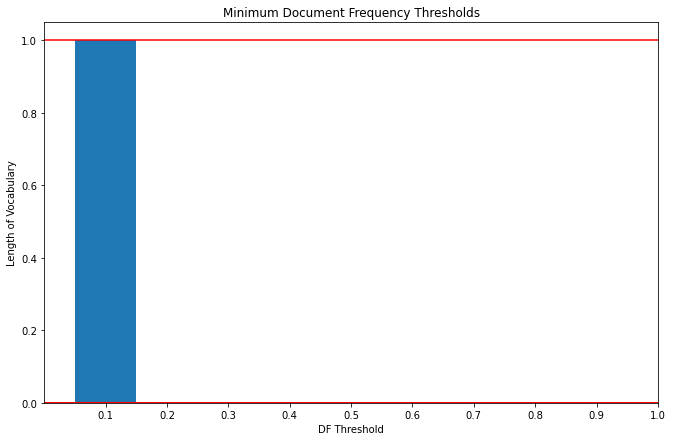

In [142]:
# Plot Minimum Document Frequency Threshold
x = np.arange(0.1, 1.1, 0.1)
vocab_y = [len([ k for k,v in doc_freq.items() if v >= thresh ]) for thresh in x]

fig, ax = plt.subplots(figsize=(11, 7))

ax.bar(x, vocab_y, width=0.1)

ax.set_xlim([0,1])
ax.set_title("Minimum Document Frequency Thresholds")

ax.set_xticks(x)

ax.set_xlabel("DF Threshold")
ax.set_ylabel("Length of Vocabulary")

for i, j in zip(x, vocab_y):
    ax.axhline(j, color='r')

x, vocab_y

In [144]:
all_vocabs = [[ k for k,v in doc_freq.items() if v >= thresh ] for thresh in x]
for vocab in all_vocabs:
    print("-- vocabulary (len={}): {}".format(len(vocab),vocab))

-- vocabulary (len=1): ['get']
-- vocabulary (len=0): []
-- vocabulary (len=0): []
-- vocabulary (len=0): []
-- vocabulary (len=0): []
-- vocabulary (len=0): []
-- vocabulary (len=0): []
-- vocabulary (len=0): []
-- vocabulary (len=0): []
-- vocabulary (len=0): []


In [146]:
twitter_df = twitter.groupby('gender')["text"]

In [147]:
tf = CountVectorizer()

document_tf_matrix = tf.fit_transform(document_series).todense()

#print(tf.vocabulary_)
#print(document_tf_matrix)

In [148]:
def idf(frequency_matrix):
    df =  float(len(document_tf_matrix)) / sum(frequency_matrix > 0)
    return [log(i) for i in df.getA()[0]]
#print(sorted(tf.vocabulary_))
#print(idf(document_tf_matrix))

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
document_tfidf_matrix = tfidf.fit_transform(document_series)
print(sorted(tfidf.vocabulary_))
print(document_tfidf_matrix.todense())

['aa', 'aaa', 'aaaaa', 'aaaaaaaa', 'aaaaaaall', 'aaaaahhhhhmmmm', 'aaacu', 'aaahotd', 'aaallll', 'aaand', 'aaandaa', 'aaare', 'aae', 'aam', 'aap', 'aapl', 'aaron', 'aarp', 'aau', 'aaufirst', 'ab', 'abacus', 'abandon', 'abba', 'abbi', 'abbott', 'abc', 'abcnew', 'abd', 'abduct', 'abe', 'abel', 'abhd', 'abid', 'abigailmac', 'abil', 'abilen', 'abit', 'abl', 'ablastforeverylash', 'ableg', 'ablelist', 'aboard', 'abolish', 'abolit', 'abomin', 'aborigin', 'abort', 'abound', 'about', 'aboutm', 'abouttim', 'abraham', 'abram', 'abras', 'abroad', 'absolut', 'absorb', 'abstain', 'abstent', 'absurd', 'abt', 'abtvblindspot', 'abu', 'abuilti', 'abuja', 'abus', 'abusymommi', 'abut', 'abwhour', 'abx', 'abyss', 'ac', 'aca', 'acaaaa', 'acabo', 'acac', 'academ', 'academi', 'acai', 'acal', 'acapella', 'acc', 'acceler', 'accent', 'accentonbodi', 'accept', 'access', 'accessori', 'accid', 'accident', 'accompani', 'accomplish', 'accord', 'account', 'accountaeata', 'acct', 'accumul', 'accur', 'accuraci', 'accus'